In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 19.7 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 5.8 MB 66.8 MB/s 
     |████████████████████████████████| 462 kB 76.4 MB/s 
     |████████████████████████████████| 1.4 MB 62.7 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.4 MB 32.4 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 352 kB 71.0 MB/s 
     |████████████████████████████████| 662 kB 64.9 MB/s 
     |████████████████████████████████| 238 kB 76.2 MB/s 
     |████████████████████████████████| 1.1 MB 57.0 MB/s 
     |████████████████████████████████| 2.3 MB 48.3 MB/s 
     |████████████████████████████████| 1.3 MB 56.2 MB/s 
     |████████████████████████████████| 5.8 MB 17.9 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 118 kB 77.8 MB/s 
     |████████████████████████████████| 439 kB 75.9 MB/s 
     |████████████████████████████████| 1.7 MB 58.8 MB/s 
     |████████████████████████████████| 6.0 MB 54.8 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

### Variabili Globali

In [6]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_no_bert_v3'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_nobert_v3'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))

# VOCABOLARIO
vocab_folder = 'vocab'
en_vocab_finalname = 'en_vocab_custom.txt'
it_vocab_finalname = 'it_vocab_custom.txt'

VOCAB_PATH = os.path.abspath(os.path.join(root_folder, vocab_folder))
en_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, en_vocab_finalname))
it_vocab_filenamepath = os.path.abspath(os.path.join(VOCAB_PATH, it_vocab_finalname))

## Parametri Modello

In [7]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'

# parametri per il modello
NUM_SAMPLES = 300000 
TRAIN = 18016
VALIDATION = 6016
TEST = 100

MAX_VOCAB_SIZE = 20000 # portato da 20.0000 a 200.000
EMBEDDING_DIM = 64  # --> 256  Densa non lineare relu --> 64  Densa non lineare relu (oppure Conv1D kernel=1)
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
MAX_SEQ_LENGTH = 64

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

# Ottimizzatore Adam
LEARNING_RATE_ADAM = 1e-4
BETA_1 = 0.66
BETA_2 = 0.999
EPOCHS_ADAM = 50

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

## Dataset

In [8]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

df = df[-(TRAIN+VALIDATION+TEST):].reset_index(drop=True)

# Mischio il dataset in modo che sia più uniforme tra train e test
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

print(df.iloc[-4:], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

validation_input_data = input_data[TRAIN:TRAIN+VALIDATION]
validation_target_data = target_data[TRAIN:TRAIN+VALIDATION]

test_input_data = input_data[TRAIN+VALIDATION:]
test_target_data = target_data[TRAIN+VALIDATION:]

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------VALIDATION SET---------------')
print(validation_input_data[-4:])
print(validation_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])

                                      input  \
24128   Tom wanted Mary to come home early.   
24129  Do you think we should raise prices?   
24130  I didn't know you were back in town.   
24131    How difficult is it to find a job?   

                                           target  
24128  Tom voleva che Mary venisse a casa presto.  
24129   Voi pensate che dovremmo alzare i prezzi?  
24130          Non sapevo fossi tornato in città.  
24131       Quanto è difficile trovare un lavoro?   

-----------TRAIN SET--------------
['Why are you watching this garbage?', "It'll be very difficult to explain.", 'We teach each other lots of things.', 'Do you know where Tom is taking us?']
['Perché state guardando questa spazzatura?', 'Sarà molto difficile da spiegare.', 'Ci insegnamo a vicenda molte cose.', 'Sapete dove ci sta portando Tom?']
-----------VALIDATION SET---------------
['I have recovered from my bad cold.', "He can't even float let alone swim.", "Have you received Tom's invitation

### Analisi Dati

In [9]:
print(f'Esempi nel Dataset di Train                            : {len(train_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Train        : {min(train_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Train       : {min(train_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Train        : {max(train_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Train       : {max(train_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Validation                       : {len(validation_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Validation   : {min(validation_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Validation  : {min(validation_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Validation   : {max(validation_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Validation  : {max(validation_target_data, key = len)}')
print('---------------------------------------------------------------------------------------')
print(f'Esempi nel Dataset di Test                             : {len(test_input_data)}')
print(f'Frase più corta in inglese nel Dataset di Test         : {min(test_input_data, key = len)}')
print(f'Frase più corta in italiano nel Dataset di Test        : {min(test_target_data, key = len)}')
print(f'Frase più lunga in inglese nel Dataset di Test         : {max(test_input_data, key = len)}')
print(f'Frase più lunga in italiano nel Dataset di Test        : {max(test_target_data, key = len)}')

Esempi nel Dataset di Train                            : 18016
Frase più corta in inglese nel Dataset di Train        : What do you want? "I want a dog."
Frase più corta in italiano nel Dataset di Train       : Vi aspetterò.
Frase più lunga in inglese nel Dataset di Train        : Can you tell the Jackson twins apart?
Frase più lunga in italiano nel Dataset di Train       : Per favore, non fare bollire le uova fino a farle diventare così dure.
---------------------------------------------------------------------------------------
Esempi nel Dataset di Validation                       : 6016
Frase più corta in inglese nel Dataset di Validation   : Are you in a hurry? "Not really."
Frase più corta in italiano nel Dataset di Validation  : La aspetterò.
Frase più lunga in inglese nel Dataset di Validation   : Are you, by any chance, afraid of me?
Frase più lunga in italiano nel Dataset di Validation  : Per gli adulti la tariffa generale di ammissione è di sette dollari.
-------------------

## Tokenizer

Carico il modello di tokenizer creato utilizzzando il set di dati a disposizione

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

train_en = dataset.map(lambda en, it: en)
train_it = dataset.map(lambda en, it: it)

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [11]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [12]:
exist_vocab = Path(en_vocab_filenamepath)

if not exist_vocab.exists():
  en_vocab = bert_vocab.bert_vocab_from_dataset(
      train_en.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(en_vocab_filenamepath, en_vocab)

In [13]:
exist_vocab = Path(it_vocab_filenamepath)

if not exist_vocab.exists():
  it_vocab = bert_vocab.bert_vocab_from_dataset(
      train_it.batch(MAX_VOCAB_SIZE).prefetch(tf.data.AUTOTUNE),
      **bert_vocab_args
  )

  write_vocab_file(it_vocab_filenamepath, it_vocab)

In [14]:
en_tokenizer = text.BertTokenizer(en_vocab_filenamepath, **bert_tokenizer_params)
it_tokenizer = text.BertTokenizer(it_vocab_filenamepath, **bert_tokenizer_params)

In [15]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  x = tf.concat([starts, ragged, ends], axis=1)
  # x = keras.preprocessing.sequence.pad_sequences(x.numpy(), maxlen=MAX_SEQ_LENGTH, padding='post')
  return x

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

### Creo la Classe Custom Tokenizer

In [16]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [17]:
tokenizers = tf.Module()
tokenizers.en = CustomTokenizer(reserved_tokens, en_vocab_filenamepath)
tokenizers.it = CustomTokenizer(reserved_tokens, it_vocab_filenamepath)

### Analisi Dati Tokenizzati

In [18]:
print(f'Vocabolario Inglese  : {tokenizers.en.get_vocab_size()}')
print(f'Vocabolario Italiano : {tokenizers.it.get_vocab_size()}')

Vocabolario Inglese  : 1729
Vocabolario Italiano : 2179


In [19]:
print(input_data[-2:])
print(tokenizers.en.tokenize(input_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize(input_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize(input_data[-2:])))
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.it.detokenize(tokenizers.it.tokenize(target_data[-2:])))

["I didn't know you were back in town.", 'How difficult is it to find a job?']
<tf.RaggedTensor [[2, 32, 87, 8, 43, 76, 52, 115, 169, 59, 580, 11, 3],
 [2, 99, 358, 55, 68, 51, 274, 24, 315, 23, 3]]>
[[  2  32  87   8  43  76  52 115 169  59 580  11   3   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  2  99 358  55  68  51 274  24 315  23   3   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor(
[b"i didn ' t know you were back in town ."
 b'how difficult is it to find a job ?'], shape=(2,), dtype=string)
------------------------------------------------------------------
['Non sapevo fossi tornato in città.', 'Quanto è difficile trovare un lavoro?']

In [20]:
print([min(train_input_data, key = len)])
print(tokenizers.en.tokenize([min(train_input_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([min(train_input_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([min(train_input_data, key = len)])))
print('------------------------------------------------------------------')
print([min(train_target_data, key = len)])
print(tokenizers.en.tokenize([min(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([min(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([min(train_target_data, key = len)])))

['What do you want? "I want a dog."']
<tf.RaggedTensor [[2, 71, 57, 52, 72, 23, 5, 32, 72, 24, 265, 11, 5, 3]]>
[[  2  71  57  52  72  23   5  32  72  24 265  11   5   3   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'what do you want ? " i want a dog . "'], shape=(1,), dtype=string)
------------------------------------------------------------------
['Vi aspetterò.']
<tf.RaggedTensor [[2, 45, 537, 114, 748, 614, 581, 381, 11, 3]]>
[[  2  45 537 114 748 614 581 381  11   3   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'vi aspettero .'], shape=(1,), dtype=string)


In [21]:
print([max(train_input_data, key = len)])
print(tokenizers.en.tokenize([max(train_input_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([max(train_input_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([max(train_input_data, key = len)])))
print('------------------------------------------------------------------')
print([max(train_target_data, key = len)])
print(tokenizers.en.tokenize([max(train_target_data, key = len)]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize([max(train_target_data, key = len)]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize([max(train_target_data, key = len)])))

['Can you tell the Jackson twins apart?']
<tf.RaggedTensor [[2, 85, 52, 108, 54, 530, 1293, 1124, 23, 3]]>
[[   2   85   52  108   54  530 1293 1124   23    3    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
tf.Tensor([b'can you tell the jackson twins apart ?'], shape=(1,), dtype=string)
------------------------------------------------------------------
['Per favore, non fare bollire le uova fino a farle diventare così dure.']
<tf.RaggedTensor [[2, 39, 166, 870, 173, 9, 150, 353, 628, 173, 25, 1025, 812, 1023, 35,
  173, 44, 381, 1726, 294, 29, 624, 381, 24, 628, 370, 27, 475, 484, 525,
  26, 1509, 537, 27, 571, 11, 3]]>
[[   2   39  166  870  173    9  150  353  628  173   25 1025  812 1023
    35  173   44  381 1726  294   29  624  381   24  628  370   27  

## Creazione Dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [22]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)
  en = tokenizers.en.tokenize(en) # Output is ragged.
  en = tf.concat([en, zero], 1)
  en = en[:, :MAX_SEQ_LENGTH]     # Trim to MAX_TOKENS.
  en = en.to_tensor()             # Convert to 0-padded dense Tensor

  it = tokenizers.it.tokenize(it)
  it_inputs = it[:, :-1].to_tensor()  # Drop the [END] tokens
  it_labels = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  it_inputs = tf.concat([it_inputs, zero], 1)
  it_inputs = it_inputs[:, :(MAX_SEQ_LENGTH)]

  it_labels = tf.concat([it_labels, zero], 1)
  it_labels = it_labels[:, :(MAX_SEQ_LENGTH)]

  return (en, it_inputs), it_labels

In [23]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [24]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_data, validation_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
validation_dataset = make_batches(validation_dataset)

In [25]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (en_input, it_input), it_target in train_dataset.take(1):
  print(f'Shape en input           : {en_input.shape}')
  print(f'Example en input         : {en_input[0]}')  
  print('-------------------------------------------------------')
  print(f'Shape it input           : {it_input.shape}')
  print(f'Example it input         : {it_input[0]}')  
  print(f'Shape it input           : {it_target.shape}')
  print(f'Example it target        : {it_target[0]}')  

Shape en input           : (32, 64)
Example en input         : [   2   32    8   27   81   51   90 1516  241 1249   24  607   63  204
   11    3    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
-------------------------------------------------------
Shape it input           : (32, 64)
Example it input         : [  2 190  39 106 123 697  59 724  61 164  11   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Shape it input           : (32, 64)
Example it target        : [190  39 106 123 697  59 724  61 164  11   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  

## Token and Position Embedding

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras

In [26]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [27]:
token_position_en = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.en.get_vocab_size(), EMBEDDING_DIM)
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_encoder = token_position_en(en_input, debug)
inputs_decoder = token_position_it(it_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************


## Encoder

Implmentazione di un blocco di EncoderTransformer tramite estensione della classe Layer di Keras

In [28]:
class Encoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='ENC'):
    super(Encoder, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, training=False, debug=False):
    attn_output = self.att(query=inputs,
                           value=inputs, 
                           key=inputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(inputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG ENCODER *********************')
      print(f'Shape Input Layer Encoder       : {inputs.shape}')
      print(f'Shape Output Layer Encoder      : {output.shape}')
      print('*********************************************************')

    return output

In [29]:
encoder = Encoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(inputs=inputs_encoder,
                          training=training, 
                          debug=debug)

********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 64, 64)
Shape Output Layer Encoder      : (32, 64, 64)
*********************************************************


## Decoder

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [30]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, encoder_output, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=encoder_output, 
                             value=encoder_output, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [31]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          encoder_output=outputs_encoder,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Outputs Decoder             : (32, 64, 64)
*********************************************************


## Transformer

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras

In [32]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               input_vocab_size,
               target_vocab_size,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_enc = TokenAndPositionEmbedding(max_len, input_vocab_size, embed_dim)
    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.encoder = [Encoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    inputs_encoder = self.token_pos_enc(inputs_encoder, debug)
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder.shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    encoder_output = inputs_encoder
    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      encoder_output = self.encoder[i](inputs=encoder_output, 
                                       training=training, 
                                       debug=debug) 
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           encoder_output=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [33]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.en.get_vocab_size(),
                               tokenizers.it.get_vocab_size(),
                               DROPUOT)

transformer_output = transformer((en_input, it_input), 
                                 training=training,
                                 debug=debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 64
Sequence Shape                            : [32 64]
Shape TokenAndPositionEmbedding           : (32, 64, 64)
*********************************************************
---------------- DEBUG TRANSFORMER BLOCK ----------------
inputs_encoder       : (32, 64, 64)
inputs_decoder       : (32, 64, 64)
********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 64, 64)
Shape Output Layer Encoder      : (32, 64, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 64, 64)
Shape Out

In [34]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 114752    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 token_and_position_embeddin  multiple                 143552    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 ENC (Encoder)               multiple                  135056    
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                                 
 dropout_13 (Dropout)        multiple            

## Addestramento modello conotttimizzatore ADAM

### Compilazione

In [35]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ADAM, 
                                       beta_1=BETA_1, 
                                       beta_2=BETA_2),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [36]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Addestramento

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/50
563/563 [==============================] - 190s 337ms/step - loss: 3.6880 - sparse_categorical_accuracy: 0.8039 - val_loss: 1.2701 - val_sparse_categorical_accuracy: 0.8443
Epoch 2/50
563/563 [==============================] - 185s 329ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.9067 - val_sparse_categorical_accuracy: 0.8693
Epoch 3/50
563/563 [==============================] - 181s 322ms/step - loss: 0.9134 - sparse_categorical_accuracy: 0.8695 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.8735
Epoch 4/50
563/563 [==============================] - 185s 328ms/step - loss: 0.8427 - sparse_categorical_accuracy: 0.8735 - val_loss: 0.7860 - val_sparse_categorical_accuracy: 0.8762
Epoch 5/50
563/563 [==============================] - 205s 364ms/step - loss: 0.7963 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.8825
Epoch 6/50
563/563 [==============================] - 184s 327ms/step - loss: 0.

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

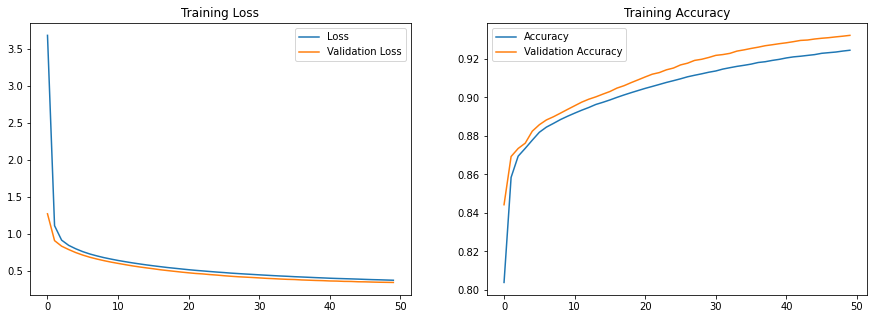

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Addestramento 2

In [37]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [38]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS_ADAM+EPOCHS_ADAM,
                          initial_epoch=EPOCHS_ADAM,
                          shuffle=True,
                          validation_data=validation_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 51/100
563/563 [==============================] - 198s 351ms/step - loss: 0.5314 - sparse_categorical_accuracy: 0.9130 - val_loss: 0.4033 - val_sparse_categorical_accuracy: 0.9275
Epoch 52/100
563/563 [==============================] - 200s 356ms/step - loss: 0.4798 - sparse_categorical_accuracy: 0.9159 - val_loss: 0.3778 - val_sparse_categorical_accuracy: 0.9290
Epoch 53/100
563/563 [==============================] - 181s 322ms/step - loss: 0.4572 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.3629 - val_sparse_categorical_accuracy: 0.9300
Epoch 54/100
563/563 [==============================] - 200s 355ms/step - loss: 0.4423 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.9314
Epoch 55/100
563/563 [==============================] - 179s 317ms/step - loss: 0.4286 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.3449 - val_sparse_categorical_accuracy: 0.9319
Epoch 56/100
563/563 [==============================] - 210s 372ms/ste

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [39]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [40]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizers.en.tokenize(input_text).to_tensor()
    inputs_encoder = keras.preprocessing.sequence.pad_sequences(inputs_encoder, maxlen=max_length, padding='post')

    # print(inputs_encoder)
    
    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      
      transformer_output = transformer([inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])

      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [41]:
test_sequences = [test_input_data[41], test_input_data[30], test_input_data[10], 
                  test_input_data[57], test_input_data[82], test_input_data[15], 
                  test_input_data[4], test_input_data[42]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[30])
print(test_target_data[10])
print(test_target_data[57])
print(test_target_data[82])
print(test_target_data[15])
print(test_target_data[4])
print(test_target_data[42])

Input:         : I've got to get back to the office.
Prediction     : ho fatto tornare in ufficio .
---------------------------------------------
Input:         : Many philosophers come from Greece.
Prediction     : molti scoluncentrani dal canke .
---------------------------------------------
Input:         : She did come, but didn't stay long.
Prediction     : lei e venuto , pero non aveva molto piu a lungo .
---------------------------------------------
Input:         : Tom said that he had a lot of money.
Prediction     : tom ha detto che aveva molto denaro .
---------------------------------------------
Input:         : Tom was murdered yesterday evening.
Prediction     : tom era assassicuteremo ieri sera .
---------------------------------------------
Input:         : Tom said you were late this morning.
Prediction     : tom ha detto che eri in ritardo questa mattina .
---------------------------------------------
Input:         : Tom and I always go home together.
Prediction    

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720